# Temporal Fusion Transformer

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


%cd /content/gdrive/My Drive/Pump Data/
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Pump Data
allpumps_nbeats.pth.tar
allpumps_tcn_v1.pth.tar
allpumps_transformer.pth.tar
data
example.ckpt
lightning_logs
lr_find_temp_model_2e56d60f-da91-4eef-a971-6f4c6883d807.ckpt
lr_find_temp_model_8b179ebf-eff3-43bd-9272-0b4cb3c6d600.ckpt
nbeats1
nbeats1residual_data.csv
nbeats2
nbeats2residual_data.csv
nbeats_valid_results.csv
optuna_test
pump1.gz
__pycache__
tcn1
tcn1residual_data.csv
tcn2
tcn2residual_data.csv
tcn_valid_results.csv
test_results.csv
trans1
trans1residual_data.csv
trans2
trans2residual_data.csv
transformers_valid_results.csv
utils.py


In [ ]:
!pip install matplotlib==3.1.3
!pip install pytorch-forecasting
!pip install darts
!pip install pyyaml==5.4.1

в этом ноутбуке смотрим реализацию https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html и считаем насколько они хорошо работают

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset
from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import warnings

import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from utils import score_model

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [3]:
FC_START = '2019-07-25 00:00:00'   # period at which to split training and validation dataset


In [4]:
valid1 = 'data/cfp_dataset_v1_valid1.csv'
valid2 = 'data/cfp_dataset_v1_valid2.csv'

In [5]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [6]:

pump_encoder = LabelBinarizer()
transformed = pump_encoder.fit_transform(training.WELL_ID)
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = pump_encoder.classes_
ohe_df.columns = ohe_df.columns.astype(str)

# training_oh = pd.concat([training, ohe_df], axis=1).drop(['WELL_ID'], axis=1)
training_oh = pd.concat([training, ohe_df], axis=1)
# training_oh
training_oh.columns = training_oh.columns.astype(str)
training_oh.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058', '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330'],
      dtype='object')

In [7]:
def get_pump_names(df):
  """
  вытаскиваем set из колонок по df, который подали
  """
  values = df.columns
  return set(values)


def split_df_by_pumps(input_df, ohe_df):
  """
  input_df: дф, в котором есть колонки onehot с насовами
  ohe_df: дф onehot для насосов
  выдает 17 штук train set
  """

  pump_ids = get_pump_names(ohe_df)
  df_list = list()

  for pump in pump_ids:
    df_list.append(input_df[input_df[pump] == 1])

  return df_list


def get_one_pump_train_date(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:
  train_target, val_target = target.split_after(pd.Timestamp(FC_START))

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399', 
       'DSHORTT1138P2300058',             '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330']]

  train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
  print(len(train_cov), len(train_target), len(val_cov), len(val_target))
  return train_cov, train_target, val_cov, val_target

def get_all_pump_training_date(df_all_pumps):
  train_cov_all, train_target_all, val_cov_all, val_target_all = [], [], [], []
  for pump_df in df_all_pumps:
    iter_train, iter_target, iter_val, iter_val_target = get_one_pump_train_date(pump_df)
    train_cov_all.append(iter_train)
    train_target_all.append(iter_target)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return train_cov_all, train_target_all, val_cov_all, val_target_all



def read_valid_pt(link, encoder):

    data = pd.read_csv(link, index_col=False)

    data.drop(['Unnamed: 0',
     'MIDUPT1138P2300058',
     'SHORTUPT1138P2300058',
     'LONGUPT1138P2300058',
     'DMIDT1138P2300058',
     'DLONGT1138P2300058',
     'UNIXDT', 'UUID'
     ], axis=1, inplace=True)
    data = data.fillna(0)
    
    transformed = encoder.transform(data.WELL_ID)
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = encoder.classes_
    df_oh = pd.concat([data, ohe_df], axis=1)
    df_oh.columns = df_oh.columns.astype(str)

    orderd_idx_i = df_oh.groupby('DT').DT.agg(['count']).sort_values('DT')
    orderd_idx_i.reset_index(inplace=True)
    orderd_idx_i['time_idx'] = orderd_idx_i.index
    orderd_idx_i.drop(['count'], axis=1, inplace=True)
    df_oh = pd.merge(df_oh, orderd_idx_i, how='left', on='DT')

    df_oh = df_oh.sort_values(['WELL_ID', 'time_idx'])
    df_oh['T1205P2300000'] = df_oh['T1205P2300000'].ffill()
    df_oh['T1013P500399'] = df_oh['T1013P500399'].ffill()
    df_oh['T1013P500399'] = df_oh['T1013P500399'].ffill()
    df_oh = df_oh.fillna(value=0)

    pump_ids = set(data.WELL_ID.unique())


    return df_oh, pump_ids

считаем и валидационную тоже

In [8]:
val1, val1pumps  = read_valid_pt(valid1, pump_encoder)
val2, val2pumps  = read_valid_pt(valid2, pump_encoder)

обучающая

In [9]:
training_oh

,WELL_ID,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058,226000188,226000198,226000297,226001846,226001947,226002142,226002148,226002307,226002416,226002603,226002627,226002861,226002998,226003074,226003080,226003316,226003330
0,226003330,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,-0.001102,0.000587,-0.000245,1.168133,70,19.6,0.759,NaN,-0.1344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,226003330,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.167644,70,19.6,0.761,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,226003330,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.161290,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,226003330,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.160802,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,226003330,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.162268,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160257,226000188,2019-06-27 07:00:00,0,14400,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.642718,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160258,226000188,2019-06-27 06:55:00,0,14100,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.648583,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160259,226000188,2019-06-27 06:50:00,0,13800,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.650049,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160260,226000188,2019-06-27 06:45:00,0,13500,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,0.001927,0.000000,0.000129,1.681818,0,0.0,0.000,NaN,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### adding idx time

In [10]:
training_oh.DT.describe()

count                  160262
unique                  10000
top       2019-07-31 23:55:00
freq                       17
Name: DT, dtype: object

In [11]:
orderd_idx = training_oh.groupby('DT').DT.agg(['count']).sort_values('DT')
orderd_idx.reset_index(inplace=True)
orderd_idx['time_idx'] = orderd_idx.index
orderd_idx.drop(['count'], axis=1, inplace=True)
orderd_idx


,DT,time_idx
0,2019-06-27 06:40:00,0
1,2019-06-27 06:45:00,1
2,2019-06-27 06:50:00,2
3,2019-06-27 06:55:00,3
4,2019-06-27 07:00:00,4
...,...,...
9995,2019-07-31 23:35:00,9995
9996,2019-07-31 23:40:00,9996
9997,2019-07-31 23:45:00,9997
9998,2019-07-31 23:50:00,9998


### joining idx time

In [12]:
training_oh = pd.merge(training_oh, orderd_idx, how='left', on='DT')

In [13]:
# all_pumps_df = split_df_by_pumps(training_oh, ohe_df)
# train_cov_v3, train_target_v3, val_cov_v3, val_target_v3= get_all_pump_training_date(all_pumps_df)

## preparing dataset

In [14]:
# define dataset
max_encoder_length = 144
max_prediction_length = 1
training_cutoff = "2019-07-25" 


this is  example code from https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

In [15]:
training_oh.head()

,WELL_ID,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058,226000188,226000198,226000297,226001846,226001947,226002142,226002148,226002307,226002416,226002603,226002627,226002861,226002998,226003074,226003080,226003316,226003330,time_idx
0,226003330,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,-0.001102,0.000587,-0.000245,1.168133,70,19.6,0.759,NaN,-0.1344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9999
1,226003330,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.167644,70,19.6,0.761,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9998
2,226003330,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.161290,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9997
3,226003330,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.160802,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9996
4,226003330,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.162268,0,0.0,0.000,NaN,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9995


это перевести в 

In [16]:
training_oh = training_oh.sort_values(['WELL_ID', 'time_idx'])

In [17]:
training_oh['T1205P2300000'] = training_oh['T1205P2300000'].ffill()
training_oh['T1013P500399'] = training_oh['T1013P500399'].ffill()
training_oh['T1013P500399'] = training_oh['T1013P500399'].ffill()
training_oh = training_oh.fillna(value=0)
           

<AxesSubplot:>

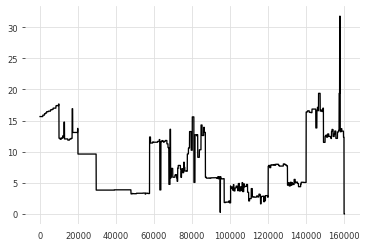

In [18]:
training_oh['T1013P500399'].plot()

In [19]:
training_oh.isnull().sum(axis = 0)

WELL_ID                0
DT                     0
T1138P6000096          0
T1138P6000315          0
DMIDT1138P4000064      0
DSHORTT1138P4000064    0
DLONGT1138P4000064     0
DMIDT1138P2600012      0
DSHORTT1138P2600012    0
DLONGT1138P2600012     0
DMIDT1205P2300000      0
DSHORTT1205P2300000    0
DLONGT1205P2300000     0
T1205P2300000          0
T1138P4000064          0
T1138P2600012          0
T1138P600050           0
T1013P500399           0
DSHORTT1138P2300058    0
226000188              0
226000198              0
226000297              0
226001846              0
226001947              0
226002142              0
226002148              0
226002307              0
226002416              0
226002603              0
226002627              0
226002861              0
226002998              0
226003074              0
226003080              0
226003316              0
226003330              0
time_idx               0
dtype: int64

In [20]:
training_oh.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058', '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330', 'time_idx'],
      dtype='object')

In [21]:

training = TimeSeriesDataSet(
    training_oh[lambda x: x.DT < training_cutoff],
    time_idx= 'time_idx',
    target= 'DSHORTT1138P2300058',
    group_ids=['WELL_ID'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals =[ '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330'],
    time_varying_known_reals=[ 'T1138P6000096',
             'T1138P6000315',   'DMIDT1138P4000064', 'DSHORTT1138P4000064',
        'DLONGT1138P4000064',   'DMIDT1138P2600012', 'DSHORTT1138P2600012',
        'DLONGT1138P2600012',   'DMIDT1205P2300000', 'DSHORTT1205P2300000',
        'DLONGT1205P2300000',       'T1205P2300000',       'T1138P4000064',
             'T1138P2600012',        'T1138P600050',        'T1013P500399' ], 
    allow_missing_timesteps=True
)

val1ds  = TimeSeriesDataSet(
    val1,
    time_idx= 'time_idx',
    target= 'DSHORTT1138P2300058',
    group_ids=['WELL_ID'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals =[ '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330'],
    time_varying_known_reals=[ 'T1138P6000096',
             'T1138P6000315',   'DMIDT1138P4000064', 'DSHORTT1138P4000064',
        'DLONGT1138P4000064',   'DMIDT1138P2600012', 'DSHORTT1138P2600012',
        'DLONGT1138P2600012',   'DMIDT1205P2300000', 'DSHORTT1205P2300000',
        'DLONGT1205P2300000',       'T1205P2300000',       'T1138P4000064',
             'T1138P2600012',        'T1138P600050',        'T1013P500399' ], 
    allow_missing_timesteps=True
)

val2ds  = TimeSeriesDataSet(
    val2,
    time_idx= 'time_idx',
    target= 'DSHORTT1138P2300058',
    group_ids=['WELL_ID'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals =[ '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330'],
    time_varying_known_reals=[ 'T1138P6000096',
             'T1138P6000315',   'DMIDT1138P4000064', 'DSHORTT1138P4000064',
        'DLONGT1138P4000064',   'DMIDT1138P2600012', 'DSHORTT1138P2600012',
        'DLONGT1138P2600012',   'DMIDT1205P2300000', 'DSHORTT1205P2300000',
        'DLONGT1205P2300000',       'T1205P2300000',       'T1138P4000064',
             'T1138P2600012',        'T1138P600050',        'T1013P500399' ], 
    allow_missing_timesteps=True
)


In [22]:

# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, training_oh, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)


valid ds prep


In [23]:

valid1_tsds = TimeSeriesDataSet.from_dataset(val1ds, val1, stop_randomization=True)
valid2_tsds = TimeSeriesDataSet.from_dataset(val2ds, val2, stop_randomization=True)

fin_val1_dataloader = valid1_tsds.to_dataloader(train=False, batch_size=batch_size, num_workers=2)
fin_val2_dataloader = valid2_tsds.to_dataloader(train=False, batch_size=batch_size, num_workers=2)



In [24]:
!nvidia-smi

Thu Dec  2 19:35:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:

# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback]
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:

# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)


In [27]:

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Number of parameters in network: 160.1k


In [ ]:

# # find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
# res = trainer.tuner.lr_find(
#     tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
# )



In [29]:
print(f"suggested learning rate: {res.suggestion()}")

suggested learning rate: 0.1067809989536307


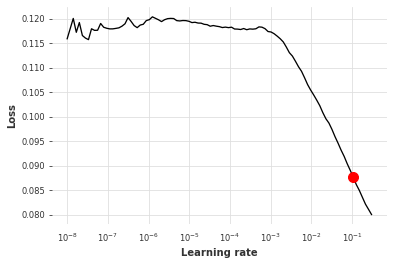

In [30]:

fig = res.plot(show=True, suggest=True)
fig.show()


In [31]:

warnings.filterwarnings("ignore")  # avoid printing out absolute paths


In [32]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1789812830607972,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)


print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 160.1k


In [33]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 36.7 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 34.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 34.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [34]:

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [35]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [36]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0387)

## запустим валиацию модели


In [103]:
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def validate_model(model,  val_dll, model_name, val_pumps):
    # create path
    Path(str(Path.cwd()) + "/" + model_name + "/").mkdir(parents=True, exist_ok=True)

    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    prediction_and_target_with_pumps = pd.DataFrame(columns=['pump_num',
                                                            'pump_name',
                                                            'true',
                                                            'predicted',
                                                            'resids',
                                                            'model'])
    
    actuals = torch.cat([y[0] for x, y in iter(val_dll)])
    predictions = model.predict(val_dll)
    testing_grps = torch.cat([x['groups'] for x, y in iter(val_dll)])

    true_values = actuals.cpu().numpy()
    predict_values = predictions.cpu().numpy()
    grp_values = testing_grps.cpu().numpy()


    pump_names = pd.DataFrame(list(val_pumps))
    for index, pump in pump_names.itertuples():


        y_true = true_values[grp_values == index]
        y_pred = predict_values[grp_values == index]


        # iterate this part over the all values
        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[index])
        results = results.append(this_key_df)
        

        

        # iterate this part over the all values


        this_key_pred_df = pd.DataFrame({'pump_num': index,
                                         'pump_name': pump,
                                         'true': y_true.flatten(),
                                         'predicted': y_pred.flatten(),
                                         'resids': (y_true - y_pred).flatten(),
                                         'model': model_name})
        

        prediction_and_target_with_pumps = prediction_and_target_with_pumps.append(this_key_pred_df)
        plt.plot(y_true[-100:], label='actual')
        plt.plot(y_pred[-100:], label='pred')
        plt.legend()
        plt.savefig(model_name + "/pump" + str(index) + "last_100.png", dpi=150)
        plt.show()

        plt.plot(y_true[:1000], label='actual_first1k')
        plt.plot(y_pred[:1000], label='pred_first1k')
        plt.legend()
        plt.savefig(model_name + "/pump" + str(index) + "first_1000.png", dpi=150)
        plt.show()

    
    prediction_and_target_with_pumps.to_csv(model_name + "residual_data.csv")
    

    return results, true_values, predict_values, prediction_and_target_with_pumps

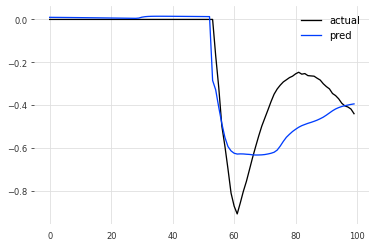

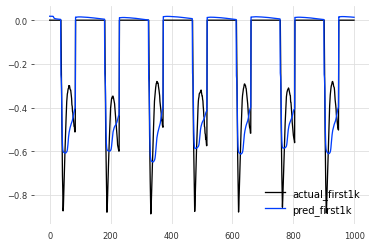

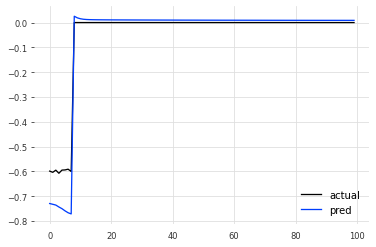

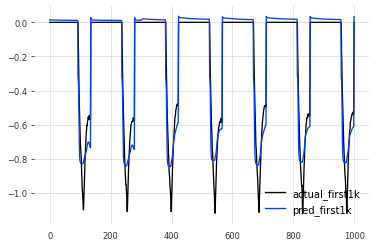

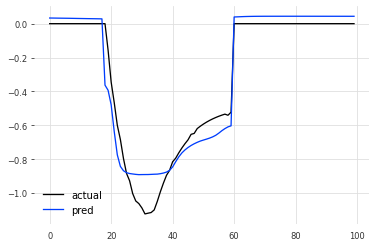

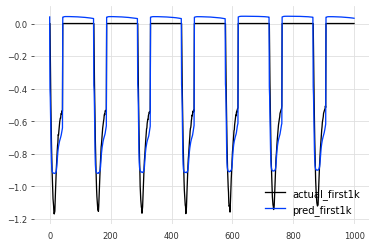

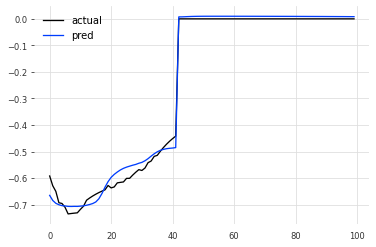

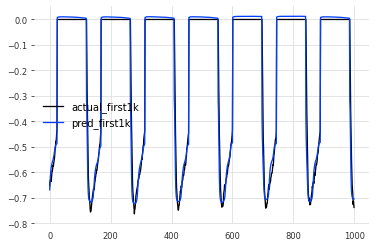

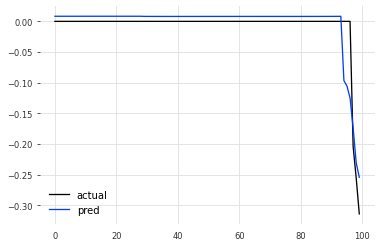

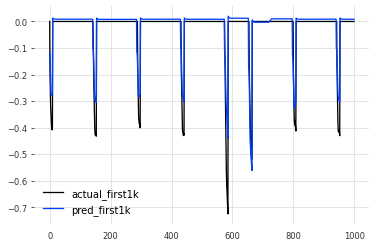

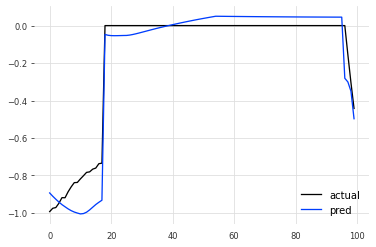

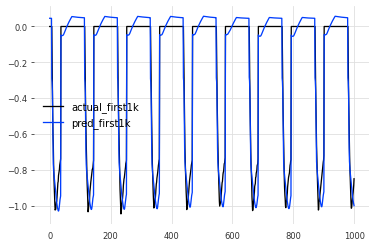

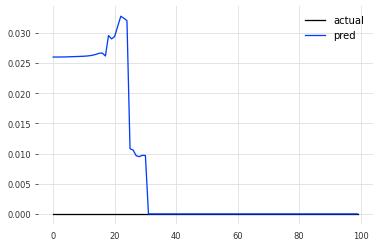

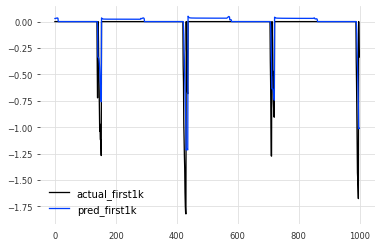

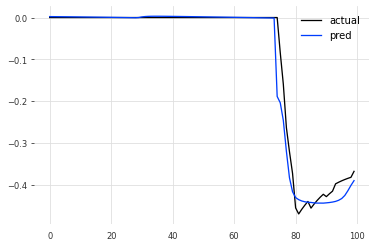

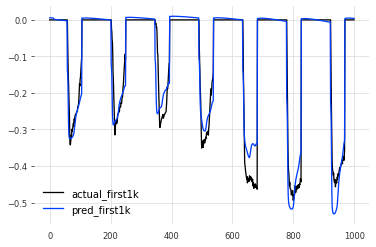

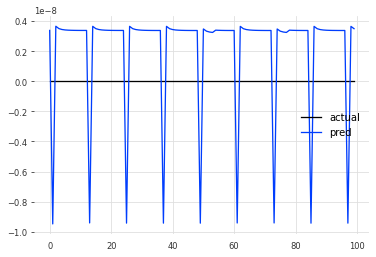

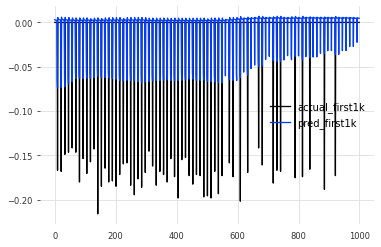

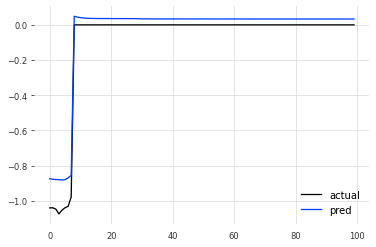

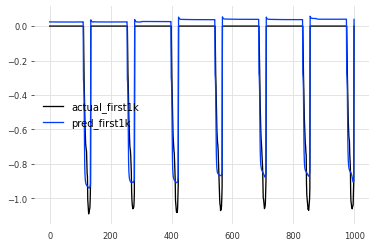

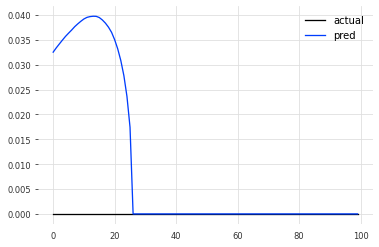

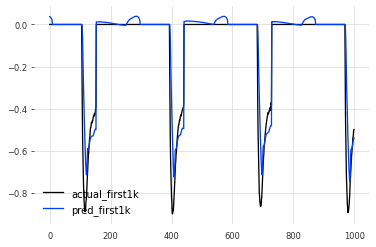

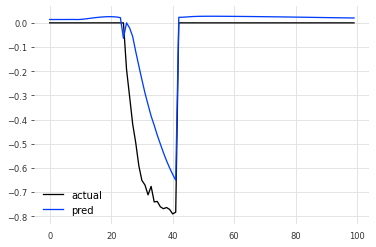

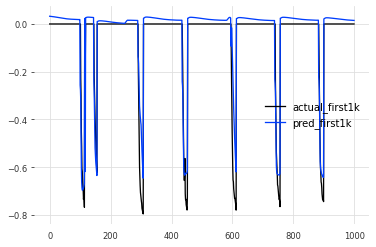

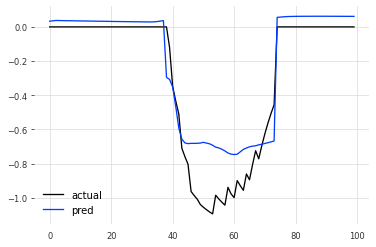

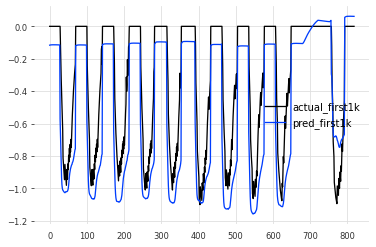

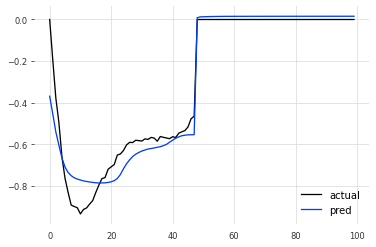

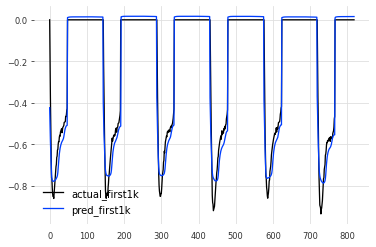

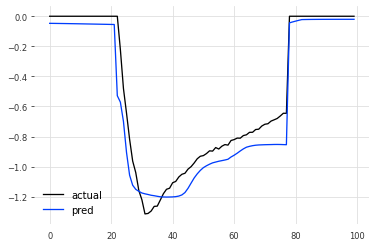

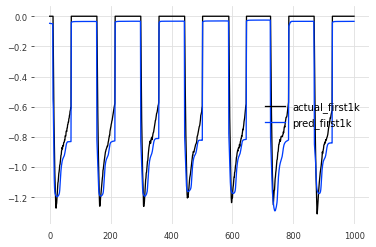

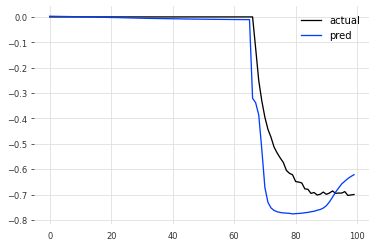

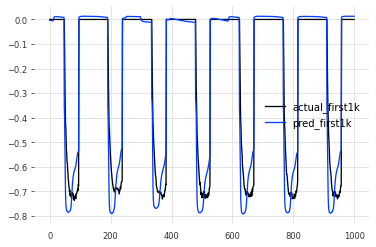

In [104]:
results_for_valid1, true_valid1, predict__valid1, resid_valid1tft = validate_model(best_tft,  fin_val1_dataloader, 'tft1', val1pumps)


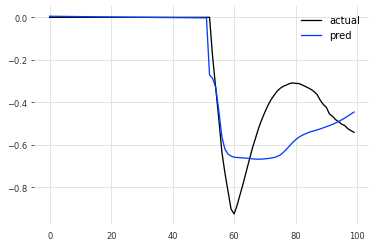

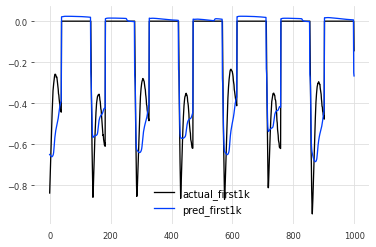

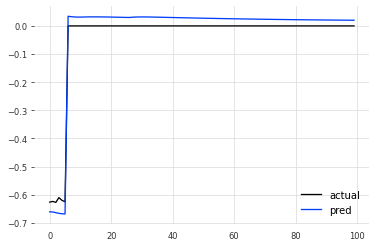

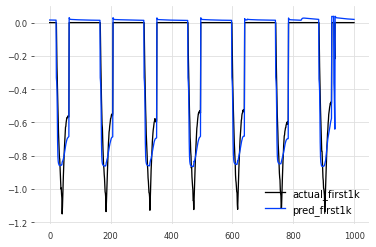

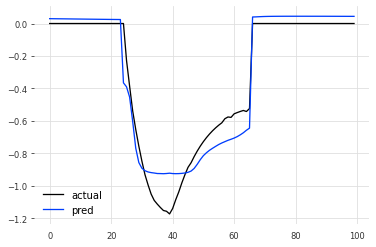

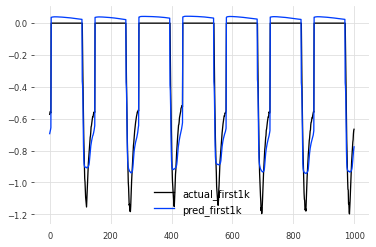

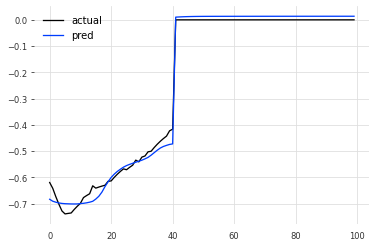

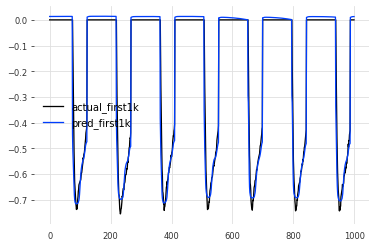

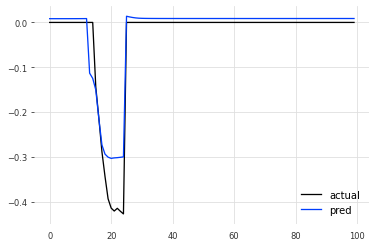

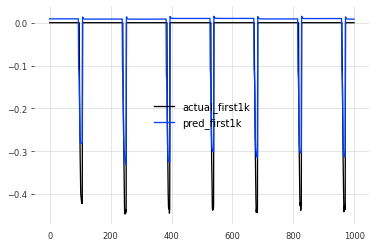

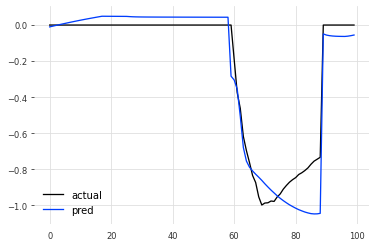

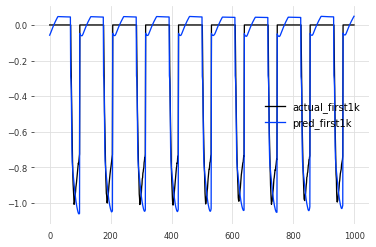

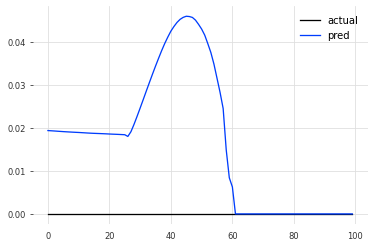

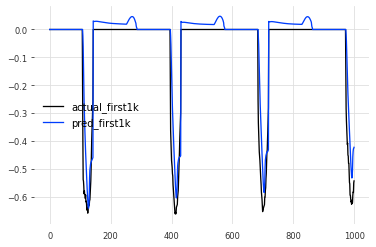

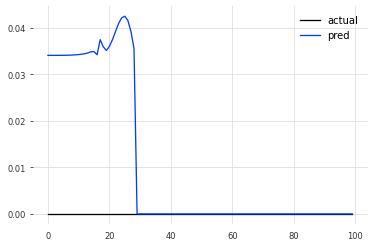

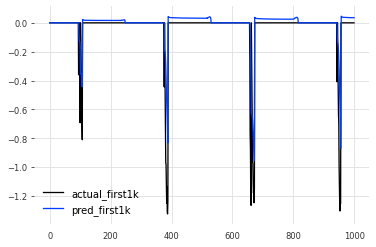

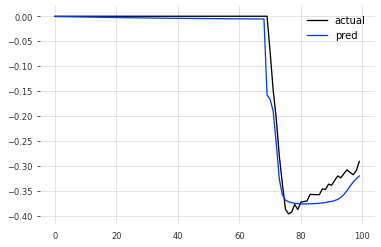

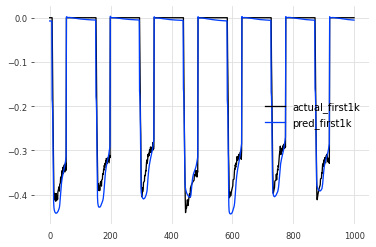

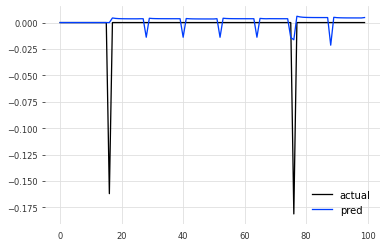

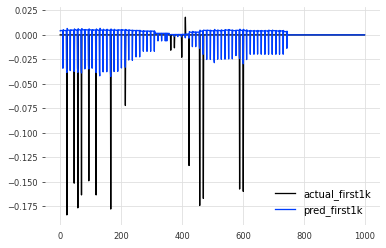

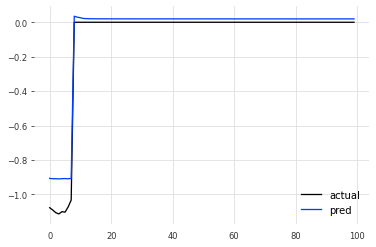

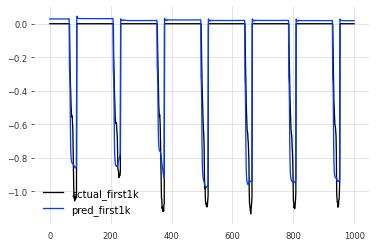

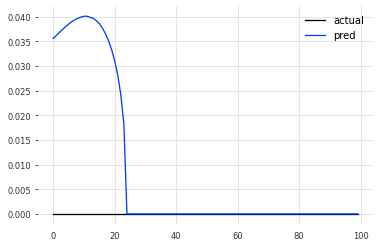

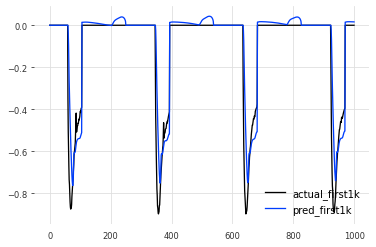

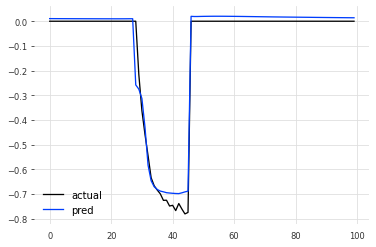

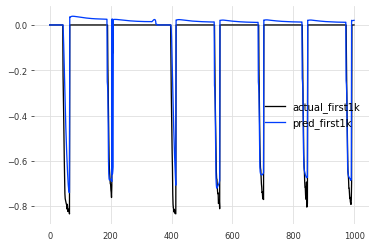

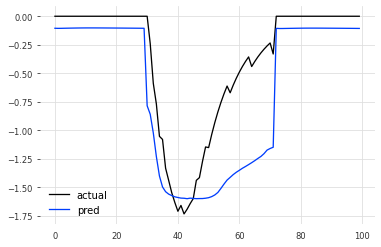

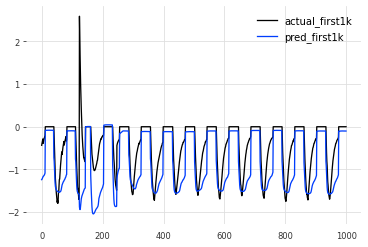

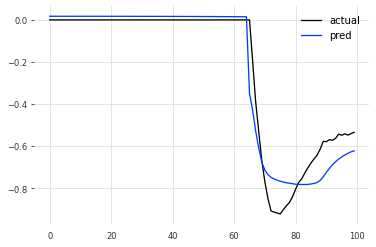

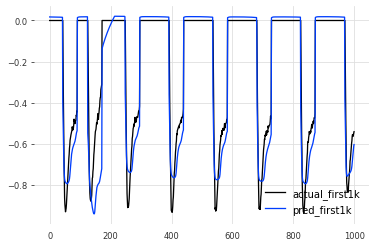

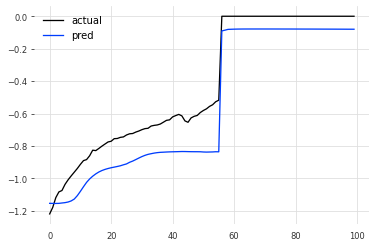

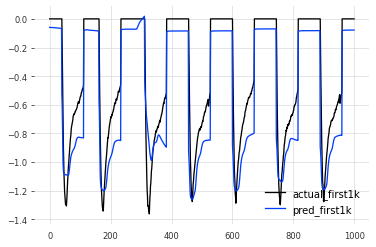

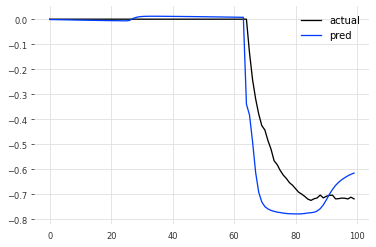

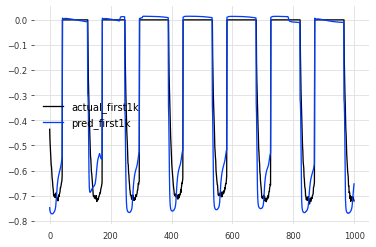

In [105]:
results_for_valid2, true_valid2, predict__valid2, resid_valid2tft = validate_model(best_tft,  fin_val2_dataloader, 'tft2', val2pumps)

In [107]:
valid_tft = {'Valid1':{'true':true_valid1, 
                      'prediction':predict__valid1}, 
             'Valid2':{'true':true_valid2, 
                      'prediction':predict__valid2}}

In [108]:
validtft_results = score_model(valid_tft)
validtft_results.loc['mean_tcn_valid'] = validtft_results.mean()

validtft_results.to_csv('tft_valid_results.csv') 
validtft_results

,mape,smape,mae,r2_value
Valid1,7.652197e+13,1.572918,0.047513,0.901942
Valid2,8.010527e+13,1.571841,0.065608,0.740382
mean_tcn_valid,7.831362e+13,1.572380,0.056561,0.821162


In [109]:
results_for_validation_dict ={'tft1'   : results_for_valid1,
                              'tft2'   : results_for_valid2}
for key, value in results_for_validation_dict.items():
  Path(str(Path.cwd()) + "/" + key+ "/").mkdir(parents=True, exist_ok=True)
  print(key, value.head())
  value.to_csv(key+ "/by_pump_valid_metrics.csv")

tft1            mape     smape       mae  r2_value
0  4.002767e+13  1.418774  0.056081  0.844172
1  6.378090e+13  1.514460  0.048015  0.936802
2  1.361672e+14  1.455807  0.063983  0.948264
3  4.028543e+13  1.378665  0.022547  0.969634
4  4.263883e+13  1.873094  0.016147  0.879618
tft2            mape     smape       mae  r2_value
0  4.414141e+13  1.406808  0.061218  0.818672
1  7.280723e+13  1.505472  0.056197  0.918016
2  1.254850e+14  1.486349  0.061377  0.951067
3  4.593480e+13  1.396521  0.023776  0.966071
4  4.604678e+13  1.882357  0.015913  0.893142


## дополнительные выводы

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);


In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [ ]:
best_tftload = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
best_tftload

In [ ]:
actuals

In [ ]:
plt.plot(predictions.cpu().numpy()[-200:], label='pred')
plt.plot(actuals.cpu().numpy()[-200:], label='true')
plt.legend()

